# Importing Libraries and Defining Constants

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import os

# Define constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 10
n_classes = 3

# Loading Dataset

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
print(class_names)


Found 1565 files belonging to 2 classes.
['Strawberry___Leaf_scorch', 'Strawberry___healthy']


# Plotting Sample Images

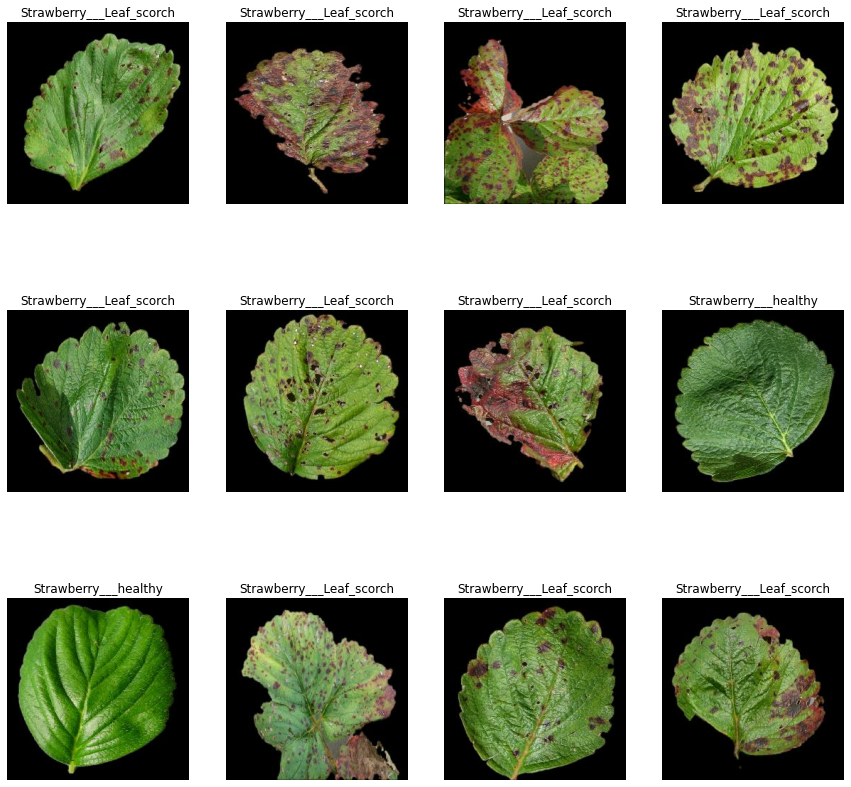

In [3]:
def plot_sample_images(dataset):
    plt.figure(figsize=(15, 15))
    for image_batch, label_batch in dataset.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[label_batch[i]])
            plt.axis("off")
    plt.show()

plot_sample_images(dataset)


# Partitioning Dataset

In [4]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Train dataset size: {len(train_ds)}")
print(f"Validation dataset size: {len(val_ds)}")
print(f"Test dataset size: {len(test_ds)}")


Train dataset size: 39
Validation dataset size: 4
Test dataset size: 6


# Defining Model Creation Function and Utility Functions

Training the model
Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 22s 505ms/step - accuracy: 0.6678 - loss: 0.7122 - val_accuracy: 0.7109 - val_loss: 0.5812
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 481ms/step - accuracy: 0.8795 - loss: 0.2648 - val_accuracy: 0.8906 - val_loss: 0.2919
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 465ms/step - accuracy: 0.9655 - loss: 0.0868 - val_accuracy: 1.0000 - val_loss: 0.0202
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 497ms/step - accuracy: 0.9797 - loss: 0.0642 - val_accuracy: 1.0000 - val_loss: 0.0584
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 492ms/step - accuracy: 0.9956 - loss: 0.0357 - val_accuracy: 1.0000 - val_loss: 0.0164
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 506ms/step - accuracy: 0.9902 - loss: 0.0217 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 19s 498ms/step - accuracy: 0.9992 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 5.0741e-04
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 539ms/step - accuracy: 0.9999 - 

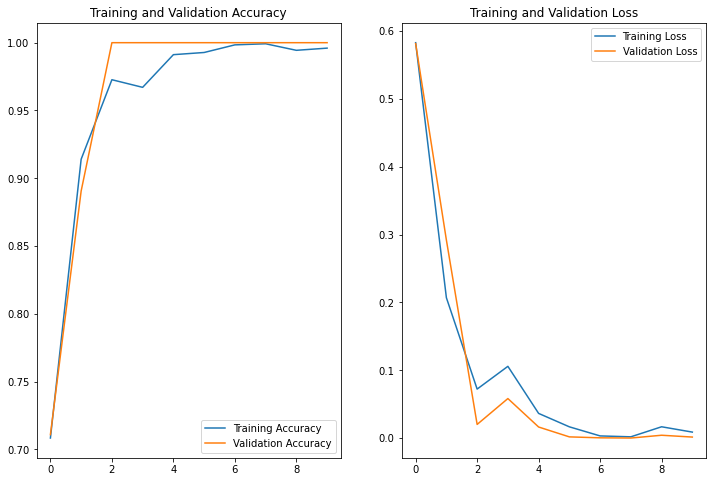

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Classification Report:
                           precision    recall  f1-score   support

Strawberry___Leaf_scorch       1.00      1.00      1.00       128
    Strawberry___healthy       1.00      1.00      1.00        64

                accuracy                           1.00       192
               macro avg       1.00      1.00      1.00       192
            weighted avg       1.00      1.00      1.00       192



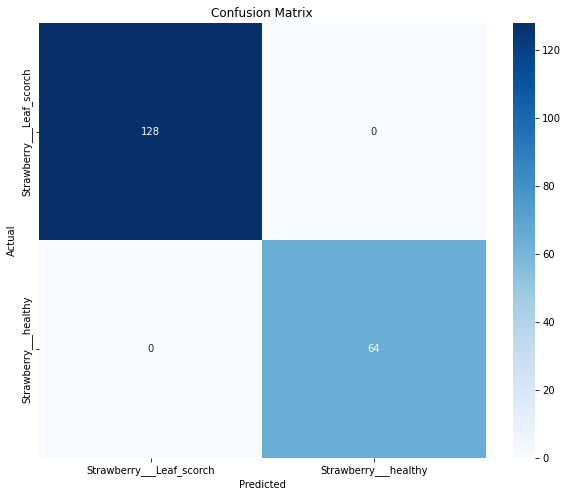

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

# Define the model creation function
def create_model(input_shape, n_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the function to plot training and validation metrics
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(EPOCHS)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Define the function to generate a classification report and confusion matrix
def classification_report_and_confusion_matrix(model, test_ds):
    y_true = []
    y_pred = []
    for images_batch, labels_batch in test_ds:
        batch_prediction = model.predict(images_batch)
        y_true.extend(labels_batch.numpy())
        y_pred.extend(np.argmax(batch_prediction, axis=1))

    # Classification report
    class_report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", class_report)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['Strawberry___Leaf_scorch', 'Strawberry___healthy']  

# Define the input shape and train the model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

print("Training the model")
model = create_model(input_shape, n_classes)
history = model.fit(train_ds, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=val_ds)

# Plot training and validation metrics
plot_metrics(history)

# Generate classification report and confusion matrix
classification_report_and_confusion_matrix(model, test_ds)

# Saving the Model

In [6]:
import os
import tensorflow as tf

# Define the directory path
directory_path = r'C:\Users\RITUJA\strawberry disease\training'

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Save the model
model_path = os.path.join(directory_path, 'strawberry.keras')
tf.keras.models.save_model(model, model_path)

print("Model saved at:", model_path)


Model saved at: C:\Users\RITUJA\strawberry disease\training\strawberry.keras
